In [18]:
# CODE_PATH = "/content/drive/MyDrive/Mestrado/Dev/devcodes/deberta"
CODE_PATH = "../trainer"

In [19]:
import sys
sys.path.append(CODE_PATH)

In [20]:
import os

import torch
import torchvision as tv
from transformers import AutoTokenizer

from ignite.engine import (
    Engine,
    Events,
)
from ignite.handlers import Checkpoint
from ignite.contrib.handlers import global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.neptune_logger import NeptuneLogger

In [21]:
from datamodule import IAMDataModule
from model import OCRModel, AbstractCNN
from ctc import GreedyDecoder
from igmetrics import ExactMatch, WordF1

In [22]:
tokenizer = AutoTokenizer.from_pretrained(f"{CODE_PATH}/iam-tokenizers/tokenizer-pad0")
decoder = GreedyDecoder(tokenizer.pad_token_id)

In [23]:
tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.vocab_size

(1, 0, 84)

In [24]:
if tokenizer.eos_token_id is None:
    tokenizer.eos_token = tokenizer.sep_token
    tokenizer.eos_token_id = tokenizer.sep_token_id

In [25]:
tokenizer.eos_token, tokenizer.eos_token_id

('</s>', 1)

# Loader

In [26]:
DATA_PATH = "../data/IAM/data/"
POOLER_MODE = "iam" 
# POOLER_MODE = "crnn"

In [10]:
# !unzip {DATA_PATH}/IAM.zip

In [27]:
dm = IAMDataModule(
    root_dir="../data/IAM/data/",
    label_file=os.path.join("../data/IAM/data/", "data.json"),
    tokenizer=tokenizer,
    height=128,
    num_workers=4,
    train_bs=2,
    valid_bs=2,
    val_pct=0.1,
    max_width=1024,
    do_pool=False,
    pooler_mode=POOLER_MODE,
)

In [28]:
dm.setup("fit")

# Model

In [29]:
from torch import nn
from model.cnn import Feature2Embedding

class CNNSmallDropout(AbstractCNN):
    """
    Custom CNN
    """

    def __init__(
        self,
        vocab_size: int = 100,
    ):
        super().__init__(vocab_size=vocab_size)

        self.image_embeddings = nn.Sequential(
            self.block(3, 64, st=(4, 2)),
            nn.Dropout2d(0.1),
            self.block(64, 128, st=(4, 2)),
            nn.Dropout2d(0.1),
            self.block(128, 256, st=(4, 2)),
            nn.Dropout2d(0.1),
            self.block(256, 512, st=(2, 1)),
            nn.Dropout2d(0.1),
            Feature2Embedding(),
        )
        self.lm_head = nn.Linear(512, self.vocab_size)

In [30]:
from transformers import RobertaConfig, RobertaForTokenClassification

class RobertaEncoderSmall(torch.nn.Module):
    def __init__(self, vocab_size=100):
        super().__init__()

        config_dict = {
            "architectures": ["RobertaForTokenClassification"],
            "num_labels": vocab_size,
            "attention_probs_dropout_prob": 0.1,
            "bos_token_id": 0,
            "eos_token_id": tokenizer.eos_token_id,
            "hidden_act": "gelu",
            "hidden_dropout_prob": 0.1,
            "hidden_size": 512,
            "initializer_range": 0.02,
            "intermediate_size": 768,
            "layer_norm_eps": 1e-05,
            "max_position_embeddings": 514,
            "model_type": "roberta",
            "num_attention_heads": 8,
            "num_hidden_layers": 3,
            "pad_token_id": tokenizer.pad_token_id,
            "type_vocab_size": 1,
            "vocab_size": vocab_size,
        }
        config = RobertaConfig(**config_dict)
        self.encoder = RobertaForTokenClassification(config)

    def forward(self, image_embeddings, attention_mask=None):
        outputs = self.encoder(
            inputs_embeds=image_embeddings, attention_mask=attention_mask
        )
        return outputs.logits

In [50]:
vis_model = CNNSmallDropout(vocab_size=tokenizer.vocab_size)
rec_model = RobertaEncoderSmall(vocab_size=tokenizer.vocab_size)
model = OCRModel(vis_model, rec_model)

In [55]:
batch = next(iter(dm.train_dataloader()))
with torch.no_grad():
    images, labels, attention_mask, attention_image = batch
    images_embedding = model.visual_model(images)
    logits = model.rec_model(images_embedding, attention_mask=attention_image)
    cnn_lm_logits = model.cnn_lm(images_embedding)
logits.shape, cnn_lm_logits.shape

(torch.Size([2, 128, 84]), torch.Size([2, 128, 84]))

In [53]:
from tqdm.auto import tqdm

In [34]:
_ = model.to("cuda")

In [35]:
with torch.no_grad():
    for batch in tqdm(dm.train_dataloader()):
        images, labels, attention_mask, attention_image = batch
        # to device
        images = images.to("cuda")
        labels = labels.to("cuda")
        attention_mask = attention_mask.to("cuda")
        attention_image = attention_image.to("cuda")

        images_embedding = model.visual_model(images)

        assert images.shape[-2] == 128
        assert images_embedding.shape[-1] == 512
        assert images_embedding.shape[1] == attention_image.shape[-1]
        assert labels.shape[-1] == attention_mask.shape[-1]

  0%|          | 0/3081 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'to'

In [36]:
images.shape

torch.Size([2, 3, 128, 1024])

In [37]:
loader_iter = iter(dm.train_dataloader())

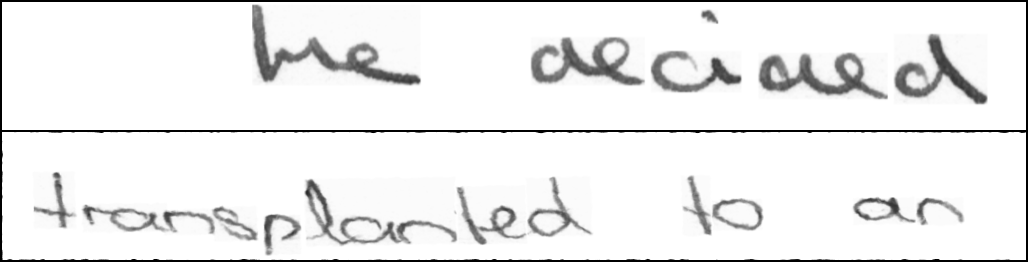

In [38]:
# display images with torchvision grid
batch = next(loader_iter)
images, labels, attention_mask, attention_image = batch
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [39]:
images.shape

torch.Size([2, 3, 128, 1024])

In [48]:
images.shape, labels.shape, attention_mask.shape, #attention_image.shape

(torch.Size([2, 3, 128, 1024]), torch.Size([2, 45]), torch.Size([2, 45]))

# Ignite

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
_ = model.to(device)

In [58]:
val_loader = dm.val_dataloader()
train_loader = dm.train_dataloader()

In [59]:
MAX_EPOCHS=30
STEPS = len(train_loader) * MAX_EPOCHS
STEPS

92430

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS, 1e-6)
criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True)#, reduction="none")

In [61]:
def get_preds_from_logits(logits, attention_image, labels):
    decoded_ids = logits.argmax(-1).squeeze(0)
    if len(decoded_ids.shape) == 1:
        decoded_ids = decoded_ids.unsqueeze(0)
    
    if attention_image is None:
        attention_image = len(decoded_ids) * [None]

    decoded = [
        decoder(dec, att) for dec, att in zip(decoded_ids, attention_image)
    ]
    y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
    y = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return y_pred, y

In [62]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    images, labels, attention_mask, attention_image = [x.to(device) if x is not None else x for x in batch]

    images_embedding = model.visual_model(images)
    logits = model.rec_model(images_embedding, attention_mask=attention_image)

    if attention_image is not None:
        input_length = attention_image.sum(-1)
    else:
        input_length = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.int32,
        )

    target_length = attention_mask.sum(-1)

    logits = logits.permute(1, 0, 2)
    logits = logits.log_softmax(2)

    loss = criterion(logits, labels, input_length, target_length)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    lr_scheduler.step()
    return loss.item()

In [63]:
def val_step(engine, batch):
    model.eval()
    images, labels, attention_mask, attention_image = [x.to(device) if x is not None else x for x in batch]
    with torch.no_grad():
        logits = model(images, attention_image)

    y_pred, y = get_preds_from_logits(logits, attention_image, labels)
    return y_pred, y
    

In [64]:
def log_validation_results(engine):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_f1 = metrics['f1']
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f} Avg F1: {avg_f1:.3f}")

In [65]:
trainer = Engine(train_step)
train_evaluator = Engine(val_step)
validation_evaluator = Engine(val_step)

In [66]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

ExactMatch().attach(train_evaluator, "accuracy")
ExactMatch().attach(validation_evaluator, "accuracy")
WordF1().attach(train_evaluator, "f1")
WordF1().attach(validation_evaluator, "f1")

In [67]:
!rm -rf roberta-checkpoint-models

In [30]:
to_save = {'model': model, 'optimizer': optimizer, 'lr_scheduler': lr_scheduler, 'trainer': trainer}
gst = lambda *_: trainer.state.epoch
handler = Checkpoint(
    to_save, 
    'roberta-checkpoint-models', 
    n_saved=1, 
    global_step_transform=gst,
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, handler)

In [31]:
to_save = {'model': model}
handler = Checkpoint(
    to_save, 
    "roberta-checkpoint-models",
    n_saved=1, 
    filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer)
)
validation_evaluator.add_event_handler(Events.COMPLETED, handler)

In [ ]:
neptune_logger = NeptuneLogger(
    project="i155825/OCRMsc",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOGUyY2VlOS1hZTU5LTQ2NGQtYTY5Zi04OGJmZWM2M2NlMDAifQ==",
)

neptune_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED,
    tag="training",
    output_transform=lambda loss: {"loss": loss},
)

neptune_logger.attach_output_handler(
    validation_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="validation",
    metric_names=["f1", "accuracy"],
    global_step_transform=global_step_from_engine(trainer),  
)

neptune_logger["code"].upload_files([f"{CODE_PATH}/*.py"])

https://app.neptune.ai/i155825/OCRMsc/e/OC-50


In [68]:
pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [69]:
trainer.run(train_loader, max_epochs=MAX_EPOCHS)

Validation Results - Epoch: 1  Avg accuracy: 0.000 Avg F1: 0.008


Epoch [2/30]: [348/3081]  11%|█▏        , loss=2.86 [00:35<04:38]Engine run is terminating due to exception: 


KeyboardInterrupt: 

# Test

In [ ]:
import collections
import os

from tqdm.auto import tqdm

from datamodule import TestSROIETask2DataModule

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
_ = model.to(device)

In [ ]:
!unzip {DATA_PATH}/testdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: testdata/X51005684949.jpg__21.png  
  inflating: __MACOSX/testdata/._X51005684949.jpg__21.png  
  inflating: testdata/X51005568889.jpg__42.png  
  inflating: __MACOSX/testdata/._X51005568889.jpg__42.png  
  inflating: testdata/X51008042787.jpg__31.png  
  inflating: __MACOSX/testdata/._X51008042787.jpg__31.png  
  inflating: testdata/X51006502540.jpg__21.png  
  inflating: __MACOSX/testdata/._X51006502540.jpg__21.png  
  inflating: testdata/X51005724611.jpg__47.png  
  inflating: __MACOSX/testdata/._X51005724611.jpg__47.png  
  inflating: testdata/X00016469670.jpg__17.png  
  inflating: __MACOSX/testdata/._X00016469670.jpg__17.png  
  inflating: testdata/X51006466070.jpg__7.png  
  inflating: __MACOSX/testdata/._X51006466070.jpg__7.png  
  inflating: testdata/X51005724628.jpg__64.png  
  inflating: __MACOSX/testdata/._X51005724628.jpg__64.png  
  inflating: testdata/X51006555819.jpg__55.png  
  inflating: __MACOSX/testdata

In [ ]:
dm = TestSROIETask2DataModule(
    root_dir="testdata",
    label_file=os.path.join(DATA_PATH, "testdata.json"),
    tokenizer=tokenizer,
    height=32,
    num_workers=4,
    train_bs=16,
    valid_bs=64,
    val_pct=0.1,
    max_width=None,
    do_pool=True,
    pooler_mode=POOLER_MODE
)

In [ ]:
dm.setup("fit")

In [ ]:
test_loader = dm.test_dataloader()

In [ ]:
handler.last_checkpoint

PosixPath('/content/drive/MyDrive/Mestrado/Dev/devcodes/deberta/roberta-checkpoint-models/best_model_28_accuracy=0.7983.pt')

In [ ]:
# ckpt_path = "/content/drive/MyDrive/Mestrado/Dev/devcodes/deberta/roberta-checkpoint-models/best_model_17_accuracy=0.8460.pt"
state_dict = torch.load(handler.last_checkpoint)
# state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
batch_size = dm.valid_bs
img2label = dm.img2label

In [ ]:
test_results = collections.defaultdict(list)
for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
    y_pred, y = val_step(None, batch[:-1])

    names = batch[-1]

    for p, n in zip(y_pred, names):
        n = n.split(".")[0]
        test_results[n].extend(p.strip().split())

  0%|          | 0/303 [00:00<?, ?it/s]

In [ ]:
# model.eval()
# test_results = collections.defaultdict(list)
# for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):

#     images, labels, attention_mask, attention_image = [x.to(device) for x in batch[:-1]]
#     with torch.no_grad():
#         logits = model(images, attention_image)
#     decoded_ids = logits.argmax(-1).squeeze(0)
#     if len(decoded_ids.shape) == 1:
#         decoded_ids = decoded_ids.unsqueeze(0)
#     decoded = [
#         decoder(dec, att) for dec, att in zip(decoded_ids, attention_image)
#     ]
#     decoded = [
#         [d for d in dd if d.item() > 1] for dd in decoded
#     ]
#     y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
#     y = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     names = batch[-1]

#     for p, n in zip(y_pred, names):
#         n = n.split(".")[0]
#         test_results[n].extend(p.strip().split())

    # break

In [ ]:
dir_path = "testsroie"
os.makedirs(dir_path, exist_ok=True)
for key, values in test_results.items():
    with open(f"{dir_path}/{key}.txt", "w") as f:
        f.write("\n".join(values))

In [ ]:
! cd {dir_path} && zip -r sub.zip *.txt && mv sub.zip ../